In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:728)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:446)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:446)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

In [0]:
#instantiate the spark session
spark = SparkSession.builder.appName("Demo").getOrCreate()

In [0]:
# Part A1
integer = spark.sparkContext.textFile("/FileStore/tables/integer.txt")
integer.collect()

arrayRDD = integer.map(lambda x: int(x)%2)
arrayRDD.collect()

reduce = arrayRDD.map(lambda word: (word, 1))
reduce.collect()

res = reduce.reduceByKey(lambda x,y : x + y) 

print("Even Number: ", res.collect()[0][1])
print("Odd Number: ", res.collect()[1][1])    

Even Number:  514
Odd Number:  496


In [0]:
# Part A2
salary = spark.sparkContext.textFile("/FileStore/tables/salary.txt")
salary.collect()

arrayRDD = salary.map(lambda x: x.split(" "))
arrayRDD.collect()

toInt = arrayRDD.map(lambda x : (x[0], int(x[1]))) 
toInt.collect()

sumRDD = toInt.reduceByKey(lambda x,y : x + y)
salary_df = spark.createDataFrame(toInt, ["Department", "Salary"])
stats_df = salary_df.groupBy("Department").agg(
    avg("Salary").alias("Mean"),
    expr("percentile_approx(Salary, 0.5)").alias("Median"),
    stddev("Salary").alias("Std")
)
stats_df.show()


+----------+-----------------+------+------------------+
|Department|             Mean|Median|               Std|
+----------+-----------------+------+------------------+
|     Sales|17355.67661691542| 16698|10535.654471835174|
| Developer|         16106.97| 14949|  9138.15811076756|
|  Research|         16641.42| 17170|  9189.53997971574|
| Marketing|         15792.25| 13763|10002.990973181359|
|        QA|         16803.12| 17702| 9854.836040366808|
+----------+-----------------+------+------------------+



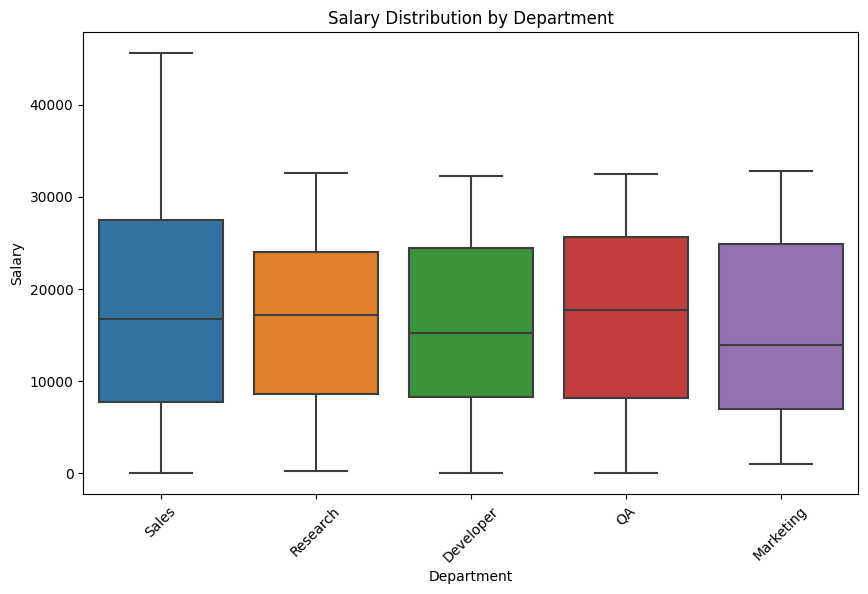

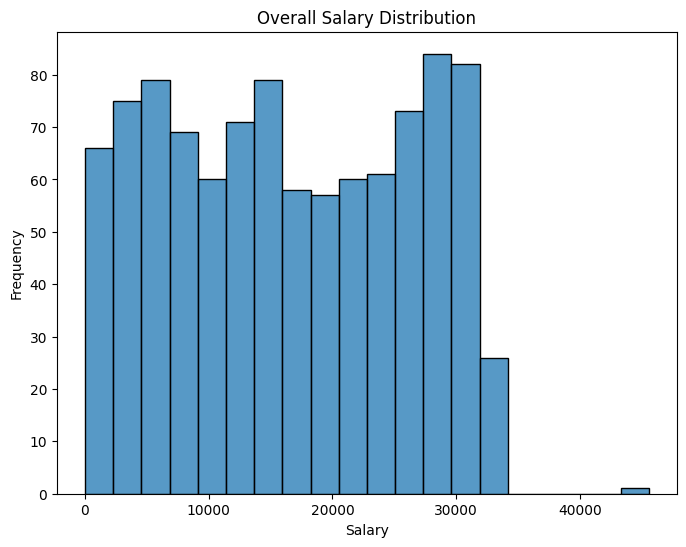

In [0]:
# Convert to Pandas for visualization
salary_pd = salary_df.toPandas()

# Boxplot for Salary Distribution
plt.figure(figsize=(10,6))
sns.boxplot(x="Department", y="Salary", data=salary_pd)
plt.title("Salary Distribution by Department")
plt.xticks(rotation=45)
plt.show()

# Histogram of Salaries
plt.figure(figsize=(8,6))
sns.histplot(salary_pd["Salary"], bins=20)
plt.title("Overall Salary Distribution")
plt.xlabel("Salary")
plt.ylabel("Frequency")
plt.show()

In [0]:
# Part A3
shakespeare = spark.sparkContext.textFile("/FileStore/tables/shakespeare_1-1.txt")

words = shakespeare.flatMap(lambda line: line.split(" "))
wordCounts = words.map(lambda word : (word, 1)).reduceByKey(lambda x,y : x+y)

result = []
word_list = ["Shakespeare", "What", "The", "Lord", "Library", "GUTENBERG", "WILLIAM", "COLLEGE", "WORLD"]
for i in wordCounts.collect():
    if i[0] in word_list:
        result.append(i)
        
result

[('Shakespeare', 22),
 ('WILLIAM', 115),
 ('COLLEGE', 98),
 ('What', 781),
 ('The', 2107),
 ('GUTENBERG', 99),
 ('Library', 2),
 ('WORLD', 98),
 ('Lord', 341)]

In [0]:
# Part A4
import re

def clean_text(line):
    line = re.sub(r"[^\w\s]", "", line)  # Remove punctuation
    words = line.lower().split()
    return words

# Apply text cleaning and word count
wordsRDD = shakespeare.flatMap(clean_text).map(lambda word: (word, 1)).reduceByKey(lambda x, y: x + y)

top_10_words = wordsRDD.sortBy(lambda x: x[1], ascending=False).take(10)
bottom_10_words = wordsRDD.sortBy(lambda x: x[1], ascending=True).take(10)

# Display results
print("Top 10 Most Common Words")
for word, count in top_10_words:
    print(f"{word}: {count}")

Top 10 Most Common Words
the: 13707
and: 12948
of: 9371
i: 9095
to: 9079
a: 6682
you: 6069
my: 5696
in: 5260
that: 5234


In [0]:
print("Bottom 10 Least Common Words")
for word, count in bottom_10_words:
    print(f"{word}: {count}")

Bottom 10 Least Common Words
restrictions: 1
reuse: 1
online: 1
wwwgutenbergorg: 1
2011: 1
release: 1
january: 1
workswilliam: 1
cdroms: 1
releases: 1


In [0]:
# Part B1
from pyspark.sql.functions import col, avg, count
# identify the top 10 movies with the highest average rating
movies = spark.sparkContext.textFile("/FileStore/tables/movies.csv")

header = movies.first()
movie_data = movies.filter(lambda row: row != header)
linedata = movie_data.map(lambda line: line.split(","))
spark_data = linedata.map(lambda fields: Row(movieId=int(fields[0]), rating=float(fields[1]), userId=int(fields[2])))
spark_df = spark.createDataFrame(spark_data)

# # Alternative Laoding method
# path = "/FileStore/tables/movies.csv"
# spark_df = spark.read \
#   .format("csv") \
#   .option("inferSchema", True) \
#   .option("header", True) \
#   .option("sep", ',') \
#   .option("path", path) \
#   .load()


top_rating = spark_df.groupBy("movieId").agg(
    avg("rating").alias('average rating'),
    count("rating").alias('rating times'),
)
top_rating = top_rating.orderBy(col("average rating"), ascending = False)
top_rating.show(10)

+-------+------------------+------------+
|movieId|    average rating|rating times|
+-------+------------------+------------+
|     32|2.9166666666666665|          12|
|     90|            2.8125|          16|
|     30|               2.5|          14|
|     94| 2.473684210526316|          19|
|     23| 2.466666666666667|          15|
|     49|            2.4375|          16|
|     29|               2.4|          20|
|     18|               2.4|          15|
|     52| 2.357142857142857|          14|
|     53|              2.25|          12|
+-------+------------------+------------+
only showing top 10 rows



In [0]:
#  top 10 users who have contributed the most ratings
top_user = spark_df.groupBy('userId').agg(
    count("rating").alias("total rating time")
)
top_user = top_user.orderBy(col("total rating time"), ascending = False)
top_user.show(10)

+------+-----------------+
|userId|total rating time|
+------+-----------------+
|     6|               57|
|    14|               57|
|    22|               56|
|    11|               56|
|    12|               55|
|     4|               55|
|     7|               54|
|     9|               53|
|    18|               52|
|    23|               52|
+------+-----------------+
only showing top 10 rows



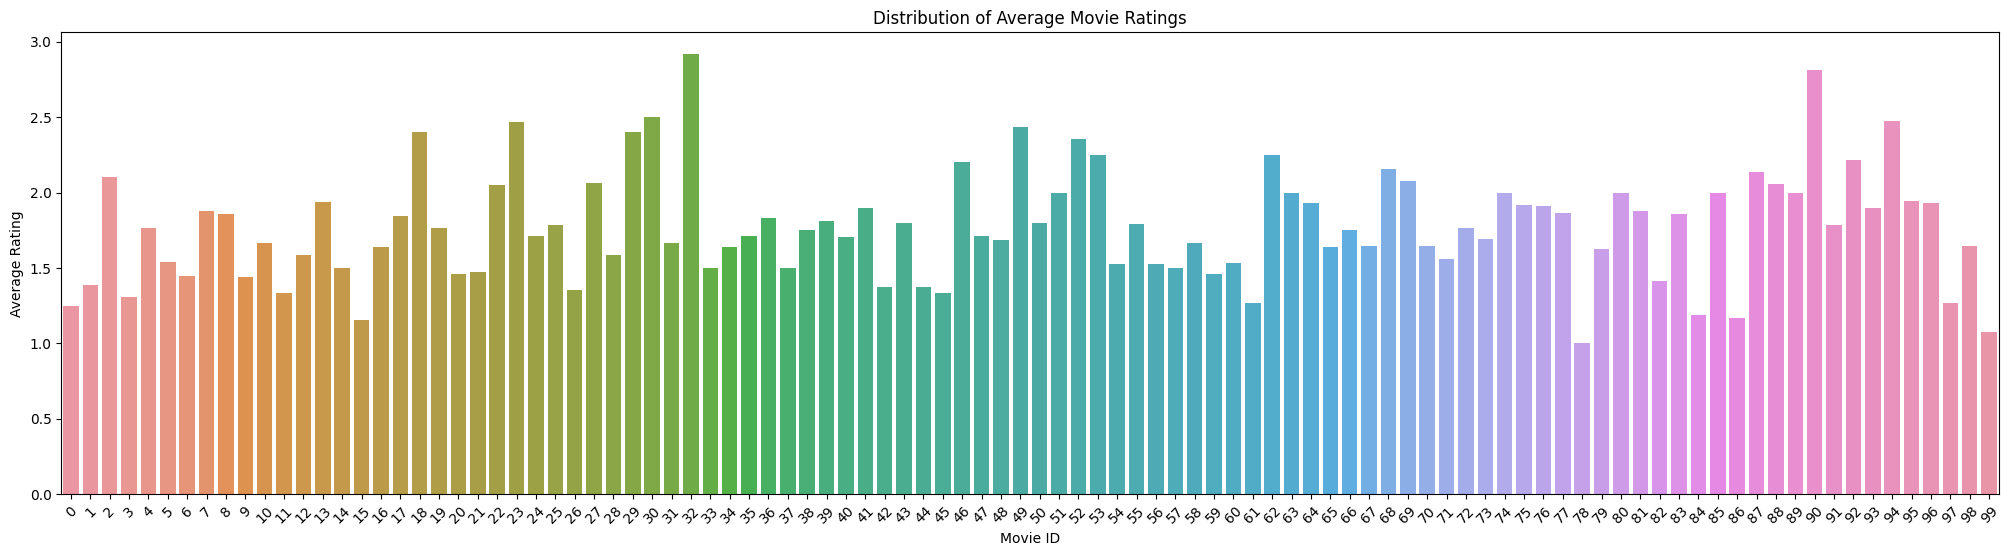

In [0]:
# Barplot of rating distribution
user_ratings_tr = top_rating.toPandas()

plt.figure(figsize=(25,6))
sns.barplot(x=user_ratings_tr['movieId'], y=user_ratings_tr['average rating'])
plt.title("Distribution of Average Movie Ratings")
plt.xlabel("Movie ID")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)
plt.show()

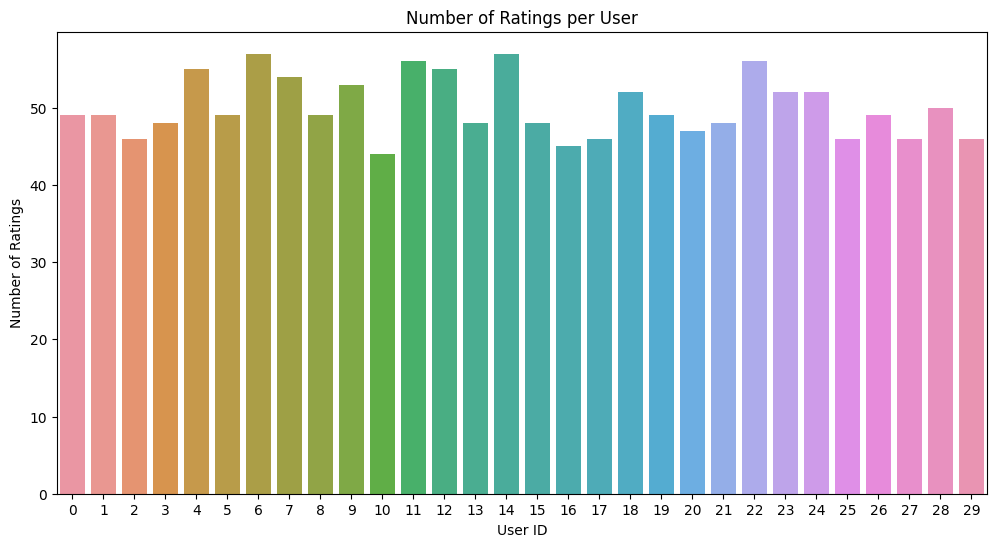

In [0]:
# Barplot of the number of ratings for each user
user_ratings = top_user.toPandas()

plt.figure(figsize=(12,6))
sns.barplot(x=user_ratings['userId'], y=user_ratings['total rating time'])
plt.title("Number of Ratings per User")
plt.xlabel("User ID")
plt.ylabel("Number of Ratings")
plt.show()


In [0]:
# Part B2
# Use randomSplit() if you want a quick, general split and are not worried about users missing from training.
# Use sampleBy() (Stratified Sampling) to ensure all users are represented proportionally in both training & test sets.

user_fractions_80_20 = {uid: 0.8 for uid in spark_df.select("userId").distinct().rdd.flatMap(lambda x: x).collect()}
user_fractions_70_30 = {uid: 0.7 for uid in spark_df.select("userId").distinct().rdd.flatMap(lambda x: x).collect()}

# Ratio1 80/20
train1 = spark_df.sampleBy("userId", fractions=user_fractions_80_20, seed=1)
test1 = spark_df.subtract(train1)

# Ratio2 70/30
train2 = spark_df.sampleBy("userId", fractions=user_fractions_70_30, seed=1)
test2 = spark_df.subtract(train2)

# Show sample sizes
print(f"Train1 (80%): {train1.count()}, Test1 (20%): {test1.count()}")
print(f"Train2 (70%): {train2.count()}, Test2 (30%): {test2.count()}")


Train1 (80%): 1208, Test1 (20%): 293
Train2 (70%): 1063, Test2 (30%): 438


In [0]:
# Part B2 continue
# Function to train and evaluate ALS Model
rmse_results = {}
def train_and_evaluate(train_df, test_df, split_name):
    als = ALS(
        maxIter=10, 
        regParam=0.1, 
        rank=10,
        userCol="userId", itemCol="movieId", ratingCol="rating",
        coldStartStrategy="drop"
    )
    model = als.fit(train_df)
    predictions = model.transform(test_df)
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    rmse = evaluator.evaluate(predictions)
    rmse_results[split_name] = rmse
    print(f"Performance for {split_name} Split:")
    print(f"RMSE: {rmse:.4f}\n")

train_and_evaluate(train1, test1, "80/20")
train_and_evaluate(train2, test2, "70/30")

Performance for 80/20 Split:
RMSE: 0.9168

Performance for 70/30 Split:
RMSE: 1.0122



In [0]:
# Part B3
# Modify my function
from pyspark.ml.evaluation import RankingEvaluator
from pyspark.sql.functions import collect_list
def train_and_evaluate_pro(train_df, test_df, split_name):
    als = ALS(
        maxIter=10, 
        regParam=0.1, 
        rank=10,
        userCol="userId", itemCol="movieId", ratingCol="rating",
        coldStartStrategy="drop"
    )
    model = als.fit(train_df)
    predictions = model.transform(test_df)

    # RMSE
    evaluator_rmse = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    rmse = evaluator_rmse.evaluate(predictions)

    # MAE
    evaluator_mae = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")
    mae = evaluator_mae.evaluate(predictions)

    # MSE
    evaluator_mse = RegressionEvaluator(metricName="mse", labelCol="rating", predictionCol="prediction")
    mse = evaluator_mse.evaluate(predictions)

    print(f"Performance for {split_name} Split:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")

In [0]:
train_and_evaluate_pro(train1, test1, "80/20")
train_and_evaluate_pro(train2, test2, "70/30")

Performance for 80/20 Split:
RMSE: 0.9168
MAE: 0.6199
MSE: 0.8406
Performance for 70/30 Split:
RMSE: 1.0122
MAE: 0.6947
MSE: 1.0245


In [0]:
from pyspark.ml.evaluation import RankingEvaluator
from pyspark.sql.functions import collect_list, col

def evaluate_precision_recall_f1(train_df, test_df, split_name):
    als = ALS(
        maxIter=10, 
        regParam=0.1, 
        rank=10,
        userCol="userId", itemCol="movieId", ratingCol="rating",
        coldStartStrategy="drop"
    )
    model = als.fit(train_df)
    predictions = model.transform(test_df)

    # Convert movieId to Double for RankingEvaluator
    predictions = predictions.withColumn("movieId", col("movieId").cast("double"))
    # Convert predictions to ranking format (Top-N recommendations)
    k = 10
    top_k_predictions = predictions.groupBy("userId").agg(collect_list("movieId").alias("predicted_items"))
    # Create Ground Truth for RankingEvaluator
    actual_items = test_df.withColumn("movieId", col("movieId").cast("double")).groupBy("userId").agg(collect_list("movieId").alias("actual_items"))
    # Join predictions with ground truth
    ranking_data = top_k_predictions.join(actual_items, "userId")

    # Precision@K
    evaluator_precision = RankingEvaluator(metricName="precisionAtK", labelCol="actual_items", predictionCol="predicted_items", k=k)
    precision = evaluator_precision.evaluate(ranking_data)

    # Recall@K
    evaluator_recall = RankingEvaluator(metricName="recallAtK", labelCol="actual_items", predictionCol="predicted_items", k=k)
    recall = evaluator_recall.evaluate(ranking_data)

    # F1 Score
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Print Performance Results
    print(f"Performance for {split_name} Split:")
    print(f"Precision@{k}: {precision:.4f}")
    print(f"Recall@{k}: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")


In [0]:
evaluate_precision_recall_f1(train1, test1, "80/20")
evaluate_precision_recall_f1(train2, test2, "70/30")

Performance for 80/20 Split:
Precision@10: 0.8833
Recall@10: 0.9315
F1 Score: 0.9068
Performance for 70/30 Split:
Precision@10: 0.9900
Recall@10: 0.7167
F1 Score: 0.8314


In [0]:
# Part B4
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

als = ALS(
    userCol="userId", 
    itemCol="movieId", 
    ratingCol="rating", 
    coldStartStrategy="drop"
)

paramGrid = ParamGridBuilder() \
    .addGrid(als.rank, [5, 10, 15]) \
    .addGrid(als.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(als.maxIter, [10, 15]) \
    .build()
    
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Perform 5-Fold Cross-Validation
crossval = CrossValidator(estimator=als, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cv_model = crossval.fit(train1)

best_model = cv_model.bestModel
best_rank = best_model.rank
best_regParam = best_model._java_obj.parent().getRegParam()
best_maxIter = best_model._java_obj.parent().getMaxIter()
print(f"Best Model Parameters: Rank = {best_rank}, RegParam = {best_regParam}, MaxIter = {best_maxIter}")

Best Model Parameters: Rank = 15, RegParam = 0.1, MaxIter = 15


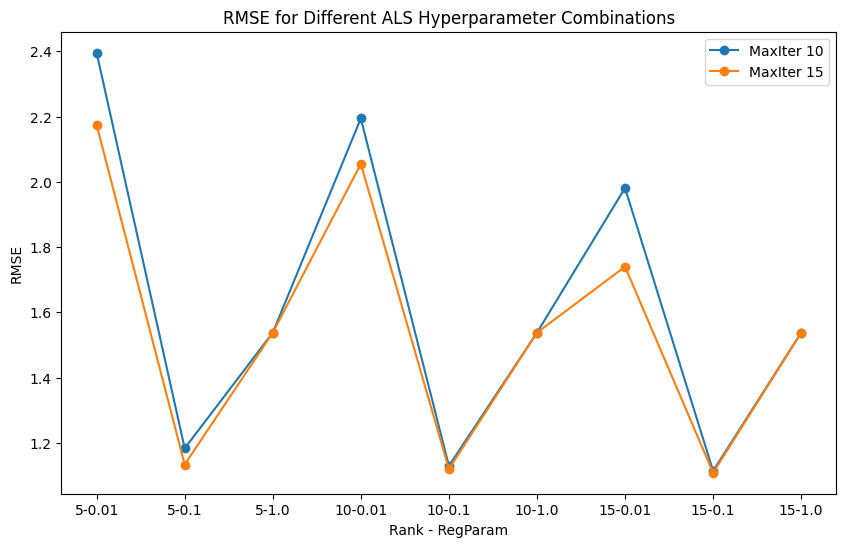

In [0]:
# Visualize the impact of different hyperparameter configurations on model RMSE scores
rmse_results = []

for i, params in enumerate(paramGrid):
    rmse = cv_model.avgMetrics[i]
    rank = [v for k, v in params.items() if "rank" in k.name][0] if any("rank" in k.name for k in params.keys()) else None
    regParam = [v for k, v in params.items() if "regParam" in k.name][0] if any("regParam" in k.name for k in params.keys()) else None
    maxIter = [v for k, v in params.items() if "maxIter" in k.name][0] if any("maxIter" in k.name for k in params.keys()) else None
    rmse_results.append((rank, regParam, maxIter, rmse))

rmse_df = pd.DataFrame(rmse_results, columns=["Rank", "RegParam", "MaxIter", "RMSE"])

# Visualize RMSE Results
plt.figure(figsize=(10,6))
for maxIter in [10, 15]:
    subset = rmse_df[rmse_df["MaxIter"] == maxIter]
    plt.plot(subset["Rank"].astype(str) + "-" + subset["RegParam"].astype(str), subset["RMSE"], 
             marker="o", label=f"MaxIter {maxIter}")
    
plt.xlabel("Rank - RegParam")
plt.ylabel("RMSE")
plt.title("RMSE for Different ALS Hyperparameter Combinations")
plt.legend()
plt.show()


In [0]:
# Part B5
# Using the hyperparameter tuned from the last question
als = ALS(
    maxIter=10, 
    regParam=0.1, 
    rank=10,
    userCol="userId", 
    itemCol="movieId", 
    ratingCol="rating",
    coldStartStrategy="drop"
)

# Fit the model to the training data
model = als.fit(train1)

user_ids = [11, 21]
users_df = spark.createDataFrame([(uid,) for uid in user_ids], ["userId"])
user_recommendations = model.recommendForUserSubset(users_df, 5)
user_recommendations.show(truncate=False)

+------+-----------------------------------------------------------------------------------+
|userId|recommendations                                                                    |
+------+-----------------------------------------------------------------------------------+
|21    |[{29, 4.1080976}, {52, 3.9067116}, {62, 3.3329737}, {63, 3.293313}, {2, 3.2366397}]|
|11    |[{27, 4.782567}, {18, 4.732108}, {32, 4.633215}, {30, 4.595777}, {23, 4.5859756}]  |
+------+-----------------------------------------------------------------------------------+



In [0]:
# Retrieve Actual Ratings Given by User 11 and 21
actual_ratings_11 = spark_df.filter(col("userId").isin(11))
top_5_actual_ratings_11 = actual_ratings_11.orderBy(col("rating").desc()).limit(5)
top_5_actual_ratings_11.show()


+-------+------+------+
|movieId|rating|userId|
+-------+------+------+
|     30|   5.0|    11|
|     79|   5.0|    11|
|     32|   5.0|    11|
|     18|   5.0|    11|
|     48|   5.0|    11|
+-------+------+------+



In [0]:
actual_ratings_21 = spark_df.filter(col("userId").isin(21))
top_5_actual_ratings_21 = actual_ratings_21.orderBy(col("rating").desc()).limit(5)
top_5_actual_ratings_21.show()

+-------+------+------+
|movieId|rating|userId|
+-------+------+------+
|     53|   5.0|    21|
|     29|   5.0|    21|
|      2|   4.0|    21|
|     74|   4.0|    21|
|     87|   4.0|    21|
+-------+------+------+

